# 1. Imports

In [1]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%pdb
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

import os
import pathlib
import logging
from typing import Optional, Union
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Custom utils for rasterio
from src.utils import get_byte_size
# Path to ESA Landcover datasets on Jasmin
from src.constants import ESA_LANDCOVER_DIR, GWS_DATA_DIR, WGS84, UTM35N
# For loading geotiff data
import xarray as xr

# Initialise the logging:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

Automatic pdb calling has been turned ON


/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# 2. Load data

## 2.1 Load land cover classes

In [2]:
# Parse land cover classes:
landcover_classes = ESA_LANDCOVER_DIR / "ESACCI-LC-Legend.csv"
classes = pd.read_csv(landcover_classes, delimiter=";", index_col=0)

print(f"There are {len(classes)} classes.")
print(classes.head())

There are 38 classes.
                                 LCCOwnLabel    R    G    B
NB_LAB                                                     
0                                    No data    0    0    0
10                         Cropland, rainfed  255  255  100
11                          Herbaceous cover  255  255  100
12                       Tree or shrub cover  255  255    0
20      Cropland, irrigated or post-flooding  170  240  240


## 2.2 Load fragmentation data

In [3]:
data_path = GWS_DATA_DIR / "esa_cci_zonal_analysis" / "esa_cci_zonal_class_analysis_full_data.nc"
data = xr.open_dataset(data_path).to_array()[0]
data

<xarray.DataArray (zone: 4, cci_landcover_class: 19, metric: 45, year: 24)>
array([[[[7.37706136e+05, 7.37616383e+05, 7.37445852e+05, ...,
          7.47731537e+05, 7.47201994e+05, 7.47201994e+05],
         [4.20076458e+01, 4.20025350e+01, 4.19928244e+01, ...,
          4.25785283e+01, 4.25483742e+01, 4.25483742e+01],
         [8.95000000e+02, 8.94000000e+02, 8.97000000e+02, ...,
          7.16000000e+02, 7.18000000e+02, 7.18000000e+02],
         ...,
         [5.57696607e+03, 5.57696607e+03, 5.57696607e+03, ...,
          5.57696607e+03, 5.57696607e+03, 5.57696607e+03],
         [4.11613014e+02, 4.11775811e+02, 4.11274937e+02, ...,
          4.46111570e+02, 4.44723314e+02, 4.44723314e+02],
         [5.00907185e+01, 5.00953531e+01, 5.00905723e+01, ...,
          5.50844422e+01, 5.49925105e+01, 5.49925105e+01]],

        [[1.25618180e+05, 1.25537402e+05, 1.25402773e+05, ...,
          1.27655571e+05, 1.27655571e+05, 1.27619670e+05],
         [7.15315186e+00, 7.14855209e+00, 7.14088581e+00, ...,
          7.26916826e+00, 7.26916826e+00, 7.26712392e+00],
         [1.80500000e+03, 1.80400000e+03, 1.80700000e+03, ...,
          1.91400000e+03, 1.91500000e+03, 1.91700000e+03],
...
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]],

        [[2.18997113e+03, 2.18997113e+03, 2.18997113e+03, ...,
          2.18997113e+03, 2.18997113e+03, 2.18997113e+03],
         [9.90581358e-01, 9.90581358e-01, 9.90581358e-01, ...,
          9.90581358e-01, 9.90581358e-01, 9.90581358e-01],
         [4.50000000e+01, 4.50000000e+01, 4.50000000e+01, ...,
          4.50000000e+01, 4.50000000e+01, 4.50000000e+01],
         ...,
         [1.49793388e+03, 1.49793388e+03, 1.49793388e+03, ...,
          1.49793388e+03, 1.49793388e+03, 1.49793388e+03],
         [2.77814552e+02, 2.77814552e+02, 2.77814552e+02, ...,
          2.77814552e+02, 2.77814552e+02, 2.77814552e+02],
         [3.30019168e+01, 3.30019168e+01, 3.30019168e+01, ...,
          3.30019168e+01, 3.30019168e+01, 3.30019168e+01]]]])
Coordinates:
  * metric               (metric) object 'total_area' ... 'euclidean_nearest_...
  * year                 (year) int16 1992 1993 1994 1995 ... 2013 2014 2015
  * cci_landcover_class  (cci_landcover_class) int32 10 11 30 40 ... 200 201 210
  * zone                 (zone) object 'E+60' ... 'Polesie Exclusion Zone'
    variable             <U29 '__xarray_dataarray_variable__'

# 3. Plotting

In [4]:
def display_class_metric(zone: str, 
                         landcover_class: Union[int, str], 
                         metrics: str,
                         fig = None, 
                         **kwargs):
    
    '''Plot the temporal variation of class metrics for different class value'''
    # Input parsing        
    if isinstance(metrics, str):
        metrics = [metrics]
        
    if isinstance(landcover_class, str):
        # Deal with string labels
        assert landcover_class in classes.LCCOwnLabel.values
        landcover_class = classes[classes.LCCOwnLabel == landcover_class].index[0]
    
    # Create figure if necessary
    if not fig:
        plt.figure(figsize=(5,2))
        
    for metric in metrics:
        metric_name = metric.replace("_", " ").capitalize()
        class_name = classes.loc[landcover_class].LCCOwnLabel
        
        plot_title = f"{metric_name}: {class_name}({landcover_class})\n {zone}"
        
        plt.title(plot_title)
        
        plt.plot(data.year, 
                 data.loc[{"zone" : zone, 
                           "cci_landcover_class": landcover_class, 
                           "metric": metric
                          }],
                 linestyle="dashed",
                 marker=".")

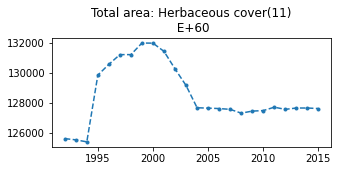

In [5]:
display_class_metric("E+60", 11, "total_area")

In [ ]:
xr.open_dataset("fragtest.nc").to_array()[0]

In [2]:
xr.open_dataset("fragtest.nc")

<xarray.Dataset>
Dimensions:                        (date: 2, landcover_class: 15, metric: 45, zone: 1)
Coordinates:
  * metric                         (metric) object 'total_area' ... 'euclidea...
  * landcover_class                (landcover_class) int32 10 11 30 ... 200 210
  * date                           (date) int32 1992 1993
  * zone                           (zone) object 'Chernobyl Exclusion Zone'
Data variables:
    __xarray_dataarray_variable__  (zone, landcover_class, metric, date) float64 ...